## 공매도 거래량 상위 50 종목의 위험도 분류

* 필요한 라이브러리 불러오기

In [46]:
import pandas as pd
import numpy as np
from pykrx import stock
import warnings
import matplotlib.pyplot as plt
warnings = warnings.filterwarnings('ignore')

#### 코스피 공매도 거래량 상위 50종목의 일일 위험도 산출 함수

In [47]:

def danger(day):

    try: 
        #데이터 불러오기#
        trade = stock.get_market_ohlcv(day)             # 해당 날짜의 KOSPI 종목 주가데이터 
        rank = stock.get_shorting_volume_top50(day)     # 공매도 거래량 상위 50종목
        name = stock.get_market_price_change(day,day)   # 종목명 컬럼 사용을 위한 데이터


        #데이터 전처리 과정# 
        name.drop(['시가','종가','거래량','거래대금','등락률'], axis=1,inplace=True)    # 종목명 추출

        many = pd.read_csv('./5years2.csv')     # 최근 5년동안 공매도 과열종목으로 지정된 기업 데이터
        many.drop(['Unnamed: 0'],axis=1,inplace=True)

        rank_trade = pd.merge(rank,trade,on="티커", how='inner')    # rank와 trade 데이터 프레임 병합
        rank_name = pd.merge(rank_trade,name,on='티커',how='inner')     # rank_trade 데이터에 종목명 추가
        rank_name.drop(['총거래대금','고가','저가','거래량','거래대금','변동폭','주가수익률'],axis=1, inplace=True)  # 컬럼 정리
        rank_name =rank_name[['종목명','시가','종가','등락률','공매도거래대금','직전40일거래대금평균', 
                                '공매도거래대금증가율','공매도비중','직전40일공매도평균비중','공매도비중증가율','순위']]    # 컬럼 순서 변경

        rank_name_many = pd.merge(rank_name,many,on='종목명',how='left')       # 공매도 과열종목 지정되었었던 종목 데이터 추가
        rank_name_many.set_index(['종목명'],inplace=True)   # 인덱스 종목코드(티커) -> 종목명으로 변경
        rank_name_many['과열횟수'] = rank_name_many['과열횟수'].fillna(0)       ## 과열횟수의 결측치를 0으로 대체
        

        #위험도 계산을 위한 for문#
        rank_name_many['위험도수치'] = 0        ## 위험도수치를 계산할 컬럼 생성
 
        for i in range(len(rank_name_many)) :       ## 공매도거래대금증가율로 위험도 측정
                if rank_name_many['공매도거래대금증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도거래대금증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도거래대금증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :       ## 공매도비중증가율로 위험도 측정
                if rank_name_many['공매도비중증가율'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['공매도비중증가율'][i] >= 2.5 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['공매도비중증가율'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['공매도비중증가율'][i] >= 1.5 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['공매도비중증가율'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :      ## 주가하락률로 위험도 측정
                if rank_name_many['등락률'][i] <= -10.0 :   
                    rank_name_many['위험도수치'][i] += 5   
                elif rank_name_many['등락률'][i] <= -8.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['등락률'][i] <= -6.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['등락률'][i] <= -4.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['등락률'][i] <= -2.0 : 
                    rank_name_many['위험도수치'][i] += 1

        for i in range(len(rank_name_many)) :           # 5년 과열종목 지정 횟수로 위험도 측정 
                if rank_name_many['과열횟수'][i] >= 5.0 :     
                    rank_name_many['위험도수치'][i] += 5
                elif rank_name_many['과열횟수'][i] >= 4.0 :
                    rank_name_many['위험도수치'][i] += 4
                elif rank_name_many['과열횟수'][i] >= 3.0 : 
                    rank_name_many['위험도수치'][i] += 3
                elif rank_name_many['과열횟수'][i] >= 2.0 : 
                    rank_name_many['위험도수치'][i] += 2
                elif rank_name_many['과열횟수'][i] >= 1.0 : 
                    rank_name_many['위험도수치'][i] += 1


        #위험도 수치를 다시 5개의 level로 분류#
        rank_name_many['위험도'] = ''  
        for i in range(len(rank_name_many)) : 
            if rank_name_many['위험도수치'][i]>= 16.0 :     
                rank_name_many['위험도'][i] ='Level5'
            elif rank_name_many['위험도수치'][i] >= 12.0 :
                rank_name_many['위험도'][i] = 'Level4'
            elif rank_name_many['위험도수치'][i] >= 8.0 : 
                rank_name_many['위험도'][i] = 'Level3'
            elif rank_name_many['위험도수치'][i] >= 4.0 : 
                rank_name_many['위험도'][i] = 'Level2'
            elif rank_name_many['위험도수치'][i] >= 0.0 : 
                rank_name_many['위험도'][i] = 'Level1'
            else:
                rank_name_many['위험도'][i] =np.NaN  
            
        return rank_name_many # 개별 종목의 위험도수치와 위험도가 포함된 데이터프레임 추출
    except:
        return '데이터가 없습니다.'

#### 지정 날짜에 찾는 종목이 공매도거래량상위50종목에 들어가는지 확인하는 함수 #

In [48]:

def choose(data):
    a = input()
    if a not in data.index:
        return '오늘은 이 종목이 존재하지 않습니다.'
    elif a in data.index:
        return data.loc[[a]]

#### 2022년 07월 8일의 위험도 산출 예시 

형식 : danger('원하는날짜')

In [49]:
df = danger('20220516')
df

,시가,종가,등락률,공매도거래대금,직전40일거래대금평균,공매도거래대금증가율,공매도비중,직전40일공매도평균비중,공매도비중증가율,순위,과열횟수,위험도수치,위험도
종목명,,,,,,,,,,,,,
메리츠증권,5910,5790,-0.34000,3357524000,1284134631,2.62000,39.71000,14.56000,2.73000,1,0.00000,8,Level3
SK,247500,245500,0.20000,14079690500,3206984963,4.39000,37.46000,8.48000,4.42000,2,0.00000,10,Level3
한화솔루션,31000,30700,0.00000,4648839100,2754638810,1.69000,35.65000,12.66000,2.82000,3,0.00000,6,Level2
넥센타이어,6490,6440,-0.77000,370917920,218194220,1.70000,35.54000,15.65000,2.27000,4,0.00000,5,Level2
세방전지,70100,67300,-2.46000,1553402400,467470333,3.32000,35.33000,9.30000,3.80000,5,1.00000,12,Level4
포스코케미칼,128500,123500,-2.76000,11406210000,6787795150,1.68000,32.35000,14.81000,2.18000,6,0.00000,6,Level2
LG디스플레이,17400,17050,-1.73000,8658102300,10400301889,0.83000,32.18000,21.09000,1.53000,7,2.00000,4,Level2
현대홈쇼핑,58000,57200,-0.52000,189835600,44224898,4.29000,29.84000,4.22000,7.07000,8,0.00000,10,Level3
미래에셋증권,7780,7730,-0.39000,1672828840,928006817,1.80000,29.36000,14.64000,2.01000,9,0.00000,5,Level2


2022년 7월 8일 공매도 거래량 상위 50종목의 위험도별 개수 시각화 

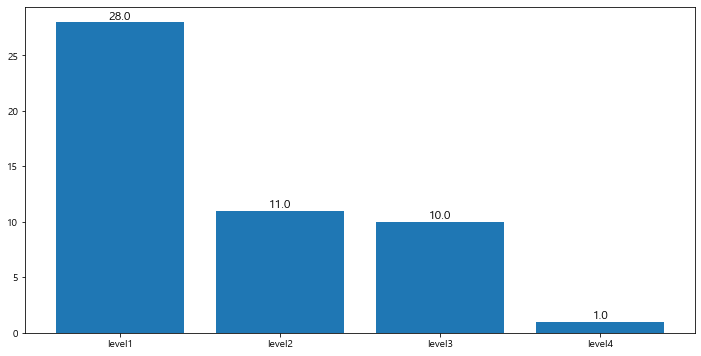

In [50]:
x = ['level1', 'level2', 'level3', 'level4']
y = pd.DataFrame(df['위험도'].value_counts())
plt.figure(figsize=(12,6))
bar = plt.bar(x,y['위험도'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f' % height, ha='center', va='bottom', size = 12)
plt.show()

#### choose(danger함수로 출력한 데이터프레임)

위 함수를 실행하여 데이터프레임 내의 인덱스(종목명)를 입력하면 입력한 종목만 볼 수 있습니다.

In [51]:
choose(df)

'오늘은 이 종목이 존재하지 않습니다.'

실제로 위험도가 level4로 가장 높게 측정된 금호석유가 그 다음주인 7월 11일에 주가가 전날대비 -7.97% 하락하며 과열종목으로 지정되었습니다.

이런 방식으로 자신이 투자하고 싶은 종목이 공매도 타겟 종목이 될 확률이 높은 종목인지 위 함수를 통해 확인할 수 있습니다.

## 머신러닝을 통한 공매도 주가하락 위험도 예측

* 데이터 추출 및 전처리

In [52]:
from pykrx import stock
import pandas as pd
import numpy as np

In [210]:
val_금호석유 = stock.get_shorting_value_by_date('20190102', '20220708', '036570')
bal_금호석유 = stock.get_shorting_balance_by_date('20190102', '20220708', '036570')
vol_금호석유 = stock.get_shorting_volume_by_date('20190102', '20220708', '036570')
sta_금호석유 = stock.get_shorting_status_by_date('20190102', '20220708', '036570')

In [211]:
for_금호석유 = stock.get_market_trading_value_by_date('20190102', '20220708', '036570')
for_ = for_금호석유['외국인합계']

In [212]:
stock_금호석유 = stock.get_market_ohlcv_by_date('20190102', '20220708', '036570')
stock_금호석유['Daily_rtn'] = stock_금호석유['종가'].pct_change()
stock_rtn = stock_금호석유['Daily_rtn']

In [213]:
pd.options.display.float_format = '{:.5f}'.format
a = val_금호석유['공매도'].rolling(40).mean().shift(1)
val_금호석유['40일'] = a

In [214]:
val_금호 = val_금호석유[40:]
val_금호['증가배율'] = np.round(val_금호['공매도'] / val_금호['40일'], 2)

증가배율 = val_금호['증가배율']
공매도거래비중 = val_금호['비중']

In [215]:
bal_금호석유 # 공매도 잔고 비중
bal_금호석유['잔고비중'] = bal_금호석유['비중']
잔고비중 = bal_금호석유['잔고비중']

In [216]:
vol_금호석유 # 공매도 거래수량

,공매도,매수,비중
날짜,,,
2019-01-02,7233,83710,8.64000
2019-01-03,4759,86434,5.51000
2019-01-04,4780,85521,5.59000
2019-01-07,8280,99745,8.30000
2019-01-08,11286,59862,18.85000
...,...,...,...
2022-07-04,12372,123724,10.00000
2022-07-05,11981,146662,8.17000
2022-07-06,4005,152793,2.62000


In [217]:
sta_금호석유
잔고수량 = sta_금호석유['잔고수량']

In [218]:
stock_gum =stock.get_market_ohlcv_by_date('20190102','20220715','036570')
stock_gum['label'] = ( stock_gum['종가'].shift(-40) - stock_gum['종가'] ) / stock_gum['종가']
labels = stock_gum['label']
labels.tail(41)

날짜
2022-05-18   -0.16533
2022-05-19        NaN
2022-05-20        NaN
2022-05-23        NaN
2022-05-24        NaN
2022-05-25        NaN
2022-05-26        NaN
2022-05-27        NaN
2022-05-30        NaN
2022-05-31        NaN
2022-06-02        NaN
2022-06-03        NaN
2022-06-07        NaN
2022-06-08        NaN
2022-06-09        NaN
2022-06-10        NaN
2022-06-13        NaN
2022-06-14        NaN
2022-06-15        NaN
2022-06-16        NaN
2022-06-17        NaN
2022-06-20        NaN
2022-06-21        NaN
2022-06-22        NaN
2022-06-23        NaN
2022-06-24        NaN
2022-06-27        NaN
2022-06-28        NaN
2022-06-29        NaN
2022-06-30        NaN
2022-07-01        NaN
2022-07-04        NaN
2022-07-05        NaN
2022-07-06        NaN
2022-07-07        NaN
2022-07-08        NaN
2022-07-11        NaN
2022-07-12        NaN
2022-07-13        NaN
2022-07-14        NaN
2022-07-15        NaN
Name: label, dtype: float64

In [219]:
kospi121 = stock.get_index_fundamental("20190102", "20220708", "1028")
kospi121.head()

,종가,등락률,PER,선행PER,PBR,배당수익률
날짜,,,,,,
2019-01-02,258.23000,-1.43000,8.41000,0.00000,0.86000,2.04000
2019-01-03,255.77000,-0.95000,8.33000,0.00000,0.86000,2.06000
2019-01-04,257.89000,0.83000,8.40000,0.00000,0.86000,2.04000
2019-01-07,261.57000,1.43000,8.52000,0.00000,0.88000,2.01000
2019-01-08,259.65000,-0.73000,8.46000,0.00000,0.87000,2.03000


In [220]:
kospi121.drop(['종가','PER','선행PER','PBR','배당수익률'],axis=1, inplace=True)

In [257]:
from functools import reduce
import pandas as pd
dfs = [for_,증가배율,공매도거래비중,잔고비중,labels]
df_merge = reduce(lambda left, right: pd.merge(left, right, on='날짜'), dfs)
df_merge

,외국인합계,증가배율,비중,잔고비중,label
날짜,,,,,
2019-03-05,563108000,0.26000,3.99000,1.13000,0.18202
2019-03-06,-514890500,0.07000,1.00000,1.12000,0.16129
2019-03-07,-2550444000,0.10000,1.26000,1.11000,0.17955
2019-03-08,-1850522500,0.25000,3.60000,1.09000,0.16376
2019-03-11,-640768500,1.08000,17.84000,1.11000,0.15402
...,...,...,...,...,...
2022-07-04,10472841500,0.82000,10.00000,0.85000,NaN
2022-07-05,10005266000,0.83000,8.17000,0.76000,NaN
2022-07-06,3723549500,0.27000,2.62000,0.68000,NaN


In [258]:
df_merge = pd.merge(df_merge,kospi121,on='날짜',how='inner')

In [259]:
df_merge

,외국인합계,증가배율,비중,잔고비중,label,등락률
날짜,,,,,,
2019-03-05,563108000,0.26000,3.99000,1.13000,0.18202,-0.73000
2019-03-06,-514890500,0.07000,1.00000,1.12000,0.16129,-0.21000
2019-03-07,-2550444000,0.10000,1.26000,1.11000,0.17955,-0.35000
2019-03-08,-1850522500,0.25000,3.60000,1.09000,0.16376,-1.45000
2019-03-11,-640768500,1.08000,17.84000,1.11000,0.15402,0.08000
...,...,...,...,...,...,...
2022-07-04,10472841500,0.82000,10.00000,0.85000,NaN,0.00000
2022-07-05,10005266000,0.83000,8.17000,0.76000,NaN,1.65000
2022-07-06,3723549500,0.27000,2.62000,0.68000,NaN,-2.18000


In [260]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('font', family='Malgun Gothic')

* features와 label 간의 상관관계 확인

<AxesSubplot:>

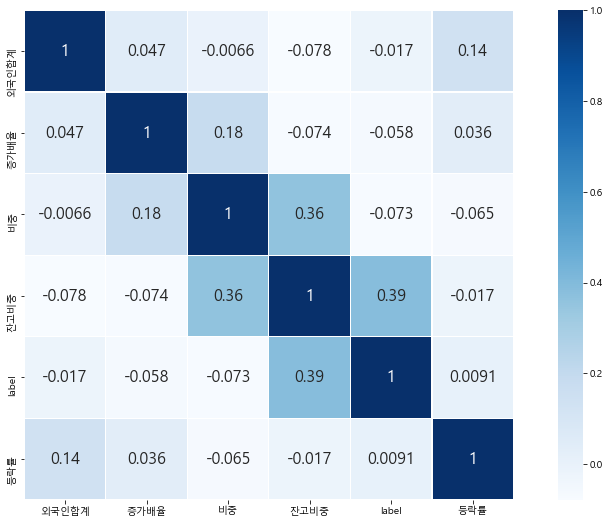

In [261]:
df_merge.corr()
plt.figure(figsize=(16,9))
sns.heatmap(df_merge.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = 'Blues', linecolor = "white", annot = True, annot_kws = {"size" : 16})

* 잔고비중과 잔고수량의 상관관계가 1로 나와, 잔고수량 feature 삭제

In [69]:
df_merge.drop(['잔고수량'], axis=1, inplace=True)
df_merge

KeyError: "['잔고수량'] not found in axis"

* label을 5일동안 수익률이 -5%일 때 1, 나머지를 0으로 설정

In [262]:
for i in range(len(df_merge)):

    if df_merge['label'][i] <= -0.04:
        df_merge['label'][i] = 1
    else :
        df_merge['label'][i] = 0

* label을 features가 있는 데이터프레임과 분리

In [263]:
df_data = df_merge.drop(['label'],axis=1)
df_target = df_merge['label']

In [264]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [265]:
df_data

,외국인합계,증가배율,비중,잔고비중,등락률
날짜,,,,,
2019-03-05,563108000,0.26000,3.99000,1.13000,-0.73000
2019-03-06,-514890500,0.07000,1.00000,1.12000,-0.21000
2019-03-07,-2550444000,0.10000,1.26000,1.11000,-0.35000
2019-03-08,-1850522500,0.25000,3.60000,1.09000,-1.45000
2019-03-11,-640768500,1.08000,17.84000,1.11000,0.08000
...,...,...,...,...,...
2022-07-04,10472841500,0.82000,10.00000,0.85000,0.00000
2022-07-05,10005266000,0.83000,8.17000,0.76000,1.65000
2022-07-06,3723549500,0.27000,2.62000,0.68000,-2.18000


* '외국인합계'와 '잔고수량'의 값이 커서 MinMaxScaler를 통해 전처리

In [266]:
from sklearn.preprocessing import MinMaxScaler
min = MinMaxScaler()
min_scaled = min.fit_transform(df_data)
minmax_fit = pd.DataFrame(min_scaled, columns=['외국인합계','증가배율', '비중', '잔고비중','등락률'])
minmax_fit

,외국인합계,증가배율,비중,잔고비중,등락률
0,0.68146,0.00505,0.09095,0.60119,0.41260
1,0.67845,0.00136,0.02279,0.59524,0.44352
2,0.67277,0.00194,0.02872,0.58929,0.43520
3,0.67472,0.00486,0.08206,0.57738,0.36980
4,0.67810,0.02100,0.40666,0.58929,0.46076
...,...,...,...,...,...
824,0.70912,0.01594,0.22795,0.43452,0.45600
825,0.70781,0.01614,0.18623,0.38095,0.55410
826,0.69028,0.00525,0.05972,0.33333,0.32640
827,0.71067,0.02080,0.23866,0.33333,0.57432


In [267]:
X_train, X_test, y_train, y_test = train_test_split(minmax_fit, df_target, test_size=0.2, random_state=56)

In [275]:
gb_clf = GradientBoostingClassifier(random_state=56)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))

GBM 정확도 : 0.7108


In [276]:
params = {'n_estimators' : [100, 150, 200], 'learning_rate' : [0.05, 0.1]}
num_folds = 10
kfold = KFold(n_splits=num_folds, random_state=56, shuffle=True)
grid_cv = GridSearchCV(gb_clf , param_grid=params, verbose=1, cv = kfold)

grid_result = grid_cv.fit(X_train, y_train)
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
최고예측 정확도: 0.7615784712799638 최적 하이퍼 파라미터 : {'learning_rate': 0.05, 'n_estimators': 100}


* XGBClassifier 모델로도 예측을 해보았으나 예측력이 좋지 않아 GBM 모델로 선정하였습니다.

In [277]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold

In [278]:
param_grid = {'n_estimators' : [100,180], 'max_depth' : [3,5], 'min_child_weight':[1,3], 'colsample_bytree':[0.5, 0.75]}
model = XGBClassifier()
num_folds = 5
scoring = 'roc_auc'
kfold = KFold(n_splits=num_folds, random_state=56, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv = kfold)
grid_result = grid.fit(X_train, y_train)
estimator = grid_result.best_estimator_
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)
pred = estimator.predict(X_test)
print(accuracy_score(y_test, pred))
print(pred)

최고예측 정확도: 0.7926831300787851 최적 하이퍼 파라미터 : {'colsample_bytree': 0.75, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.7108433734939759
[1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1
 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0]


In [279]:
from sklearn.metrics import confusion_matrix

In [280]:
confusion_matrix(y_test, pred)

array([[85, 24],
       [24, 33]], dtype=int64)

In [281]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.78      0.78      0.78       109
     class 1       0.58      0.58      0.58        57

    accuracy                           0.71       166
   macro avg       0.68      0.68      0.68       166
weighted avg       0.71      0.71      0.71       166



In [282]:
from sklearn.metrics import roc_curve

In [283]:
pred_proba_class1 = estimator.predict_proba(X_test)[:,1]

In [284]:
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0],5)


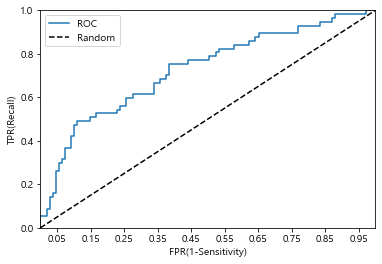

In [305]:
plt.plot(fprs, tprs, label='ROC')
plt.plot([0,1],[0,1], 'k--', label='Random')

start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1),2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()                     
plt.show()



In [287]:
import numpy as np
X = np.array([[-1, -1],
              [-2, -1],
              [ 1,  1],
              [ 2,  1]])
y = np.array([0, 0, 1, 1])
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
model.fit(X,y)
prob = model.predict_proba([[-0.8, -1]])
print('Prob[0]: %.3f' % prob[0][0])
print('Prob[1]: %.3f' % prob[0][1])
prob_result = model.predict([[-0.8, -1]])
prob_result

Prob[0]: 0.866
Prob[1]: 0.134


array([0])

In [288]:
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD


In [289]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))
# #Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))


In [290]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=10, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=10, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


LR: 0.692931 (0.053364)
LDA: 0.693487 (0.056344)
KNN: 0.760429 (0.060890)
CART: 0.696475 (0.062578)
NB: 0.711198 (0.044813)
SVM: 0.728973 (0.064171)
NN: 0.712204 (0.061480)
AB: 0.773248 (0.056123)
GBM: 0.809202 (0.040274)
RF: 0.825377 (0.043812)
ET: 0.828907 (0.033742)


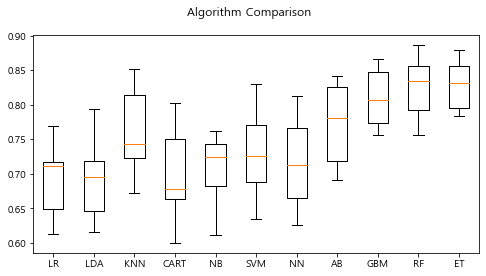

In [291]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()


In [292]:
from sklearn.model_selection import StratifiedKFold

In [293]:
n_estimators = [20,50,100]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, random_state=10, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=kfold)
grid_result = grid.fit(X_train, y_train)


In [294]:
estimator = grid_result.best_estimator_
print('최고예측 정확도:', grid_result.best_score_, '최적 하이퍼 파라미터 :', grid_result.best_params_)
pred = estimator.predict(X_test)
print(accuracy_score(y_test, pred))

최고예측 정확도: 0.8175362205545132 최적 하이퍼 파라미터 : {'max_depth': 5, 'n_estimators': 50}
0.6987951807228916


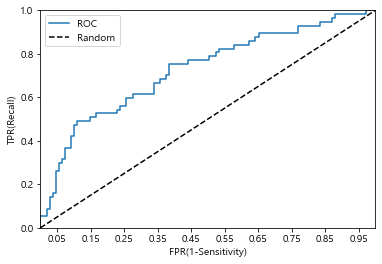

In [295]:
pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1, thresholds.shape[0],5)
plt.plot(fprs, tprs, label='ROC')
plt.plot([0,1],[0,1], 'k--', label='Random')

start, end = plt.xlim()
plt.xticks(np.round(np.arange(start, end, 0.1),2))
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
plt.legend()
plt.show()

In [296]:
print(classification_report(y_test, pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.76      0.79      0.77       109
     class 1       0.57      0.53      0.55        57

    accuracy                           0.70       166
   macro avg       0.66      0.66      0.66       166
weighted avg       0.69      0.70      0.70       166



In [297]:
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np
pred_proba = estimator.predict_proba(X_test)
custom_threshold = 0.33

# Positive 컬럼에 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

# 테스트 레이블 데이터셋: y_test

# 오차행렬
print(confusion_matrix(y_test, custom_predict))
# 정확도 : 0.8492
print(accuracy_score(y_test, custom_predict))
# 정밀도 : 0.7742
print(precision_score(y_test, custom_predict))
# 재현율 : 0.7869
print(recall_score(y_test, custom_predict))

[[60 49]
 [13 44]]
0.6265060240963856
0.4731182795698925
0.7719298245614035


In [315]:
pred_proba = estimator.predict_proba(X_test)
custom_threshold = 0.37

# Positive 컬럼에 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)

# 테스트 레이블 데이터셋: y_test

# 오차행렬
print(confusion_matrix(y_test, custom_predict))
# 정확도 : 0.8492
print(accuracy_score(y_test, custom_predict))
# 정밀도 : 0.7742
print(precision_score(y_test, custom_predict))
# 재현율 : 0.7869
print(recall_score(y_test, custom_predict))
print(classification_report(y_test, custom_predict))

[[67 42]
 [14 43]]
0.6626506024096386
0.5058823529411764
0.7543859649122807
              precision    recall  f1-score   support

         0.0       0.83      0.61      0.71       109
         1.0       0.51      0.75      0.61        57

    accuracy                           0.66       166
   macro avg       0.67      0.68      0.66       166
weighted avg       0.72      0.66      0.67       166



In [307]:
# threshold 최대값의 인덱스, np.argmax()
# pred_proba_class1 = estimator.predict_proba(X_test)[:,1]
# fprs, tprs, thresholds = roc_curve(y_test, pred_proba)
optimal_idx = np.argmax(tprs - fprs)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', threshold:', optimal_threshold)

idx: 22 , threshold: 0.5786998371286991
